In [ ]:
## Jordan's comments are dennoted by 2 #'s

## Original code available at: https://www.kaggle.com/sarthakbatra/box-office-revenue-random-forest-tutorial

In [1]:
# Data Processing and Cleaning
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

#Miscellaneous
from tqdm import tqdm_notebook

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


## Reading Data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

## Simple Models

Before using external data or performing extensive cleaning and parsing of features, let us fit the simplest linear regression and Random Forest model to get a baseline score. Before we do that though, we need to take the log of the target variable, as the competition metric is RMSLE (Root Mean Squared Log Error)

In [14]:
train['revenue'] = np.log1p(train['revenue'])

### Linear Regression

Let's perform a simple linear regression Model using just the budget feature.

In [15]:
## Dimensionality Redeuction
x = train.budget.values.reshape(-1,1)
y = train.revenue
reg = LinearRegression().fit(x, y)

In [16]:
## Accuracy
print(f'Regression Score: {reg.score(x, y)}')

## Regression Line
print(f'Regression Coefficient: {reg.coef_[0]}')
print(f'Regression Intercept: {reg.intercept_}')

Regression Score: 0.24444198948839246
Regression Coefficient: 4.053640806959413e-08
Regression Intercept: 15.054164708014042


In [17]:
## Only using 'budget' feature to predict 'revenue' values

predictions = reg.predict(test['budget'].values.reshape(-1,1))

#### Preparing Submission for Linear Regression

In [18]:
submission['revenue'] = np.round(np.expm1(predictions))

In [19]:
submission.to_csv('submission_budget_linreg.csv', index = False)

This gives us a Kaggle score of *2.71*, and would place you around the top 75th percenticle of this competition. It is a significant improvement over the default predictions, which led to a Kaggle score of *3.79*. We have barely used any brainpower so this is not bad at all.

### Random Forest

In [20]:
rf_cols = ['budget', 'original_language', 'popularity', 'release_date', 'runtime', 'status', 'homepage', 'overview', 'revenue']
rf_train = train[rf_cols].copy()
rf_cols.remove('revenue')
rf_test = test[rf_cols].copy()

#### Budget Feature
Fill zero values for the budget feature in train and test data with median of the feature in the train set. We shall use only the train set to calculate median budget. This will avoid data leakage. We will also create another binary feature, *'budget_is_median'* which will hold the value 1 for indices that have been filled with median budget

In [21]:
median_budget = rf_train[rf_train['budget'] > 0]['budget'].median()
median_budget

16000000.0

In [22]:
def fill_budget(df, median_budget):
    df['budget_is_median'] = 0
    df.loc[df.budget == 0, 'budget_is_median'] = 1
    df.loc[df.budget == 0, 'budget'] = median_budget
    return df

In [23]:
## Fills missing budget values (in both test and train data) with median of budget values in training data

rf_train = fill_budget(rf_train, median_budget)
rf_test = fill_budget(rf_test, median_budget)

#### Original Language Feature
We will label encode this categorical feature using sklearn. For now, let's do this in the simplest manner and not worry about any smart encoding. We will have to concatenate the train and test set in order before fitting the label encodings

In [24]:
rf_combined = pd.concat([rf_train, rf_test], sort=False)

In [25]:
## Encodes all possible values for 'orginal_language'

le = LabelEncoder()
le.fit(rf_combined['original_language'])
rf_train['original_language'] = le.transform(rf_train['original_language'])
rf_test['original_language'] = le.transform(rf_test['original_language'])

#### Status Feature
We will deal with the *Status* categorical feature in the same manner. From our EDA section, we know that there are 2 missing values in the test set. Let's replace these values with the most common occurence of the variable, *'Released'*

In [26]:
## Replaces null values in 'status' with 'Released'

rf_test.loc[rf_test['status'].isnull() == True, 'status'] = 'Released'
rf_combined.loc[rf_combined['status'].isnull() == True, 'status'] = 'Released'

In [27]:
le = LabelEncoder()
le.fit(rf_combined['status'])
rf_train['status'] = le.transform(rf_train['status'])
rf_test['status'] = le.transform(rf_test['status'])

#### Homepage Feature

This feature will store 0 for movies that don't have a homepage, and 1 for movies that do.

In [28]:
## Binarize homepage from homepage url to has a homepage as 1 and data does not contain a homepage as 0

rf_train.loc[rf_train['homepage'].isnull() == True, 'homepage'] = 0
rf_train.loc[rf_train['homepage'].isnull() == False, 'homepage'] = 1

rf_test.loc[rf_test['homepage'].isnull() == True, 'homepage'] = 0
rf_test.loc[rf_test['homepage'].isnull() == False, 'homepage'] = 1

#### Runtime Feature
We have some null values for *Runtime* feature. There are also some values that have the value 0. Let's fill them with the median value for runtime from the train set.

In [29]:
median_runtime = rf_train['runtime'].median()
median_runtime

104.0

In [30]:
def fill_runtime(df, median_runtime):
    df['runtime_is_median'] = 0
    df.loc[df.runtime == 0, 'runtime_is_median'] = 1
    df.loc[df.runtime.isnull() == True, 'runtime_is_median'] = 1
    df.loc[df.runtime == 0, 'runtime'] = median_runtime
    df.loc[df.runtime.isnull() == True, 'runtime'] = median_runtime
    return df

In [31]:
## Replaces null 'runtime' values with median

rf_train = fill_runtime(rf_train, median_runtime)
rf_test = fill_runtime(rf_test, median_runtime)

#### Release Data Feature

Parse release date and extract features such as day, month, year!

In [32]:
from datetime import timedelta, date

Filling missing data with external ground truth

In [33]:
rf_test.loc[rf_test['release_date'].isnull() == True, 'release_date'] = '10/19/2001'
test.loc[test['release_date'].isnull() == True, 'release_date'] = '10/19/2001'

In [34]:
def add_date_features(df, col, prefix):
    df[col] = pd.to_datetime(df[col])
    future = df[col] > pd.Timestamp(year=2017,month=12,day=31)
    df.loc[future, col] -= timedelta(days=365.25*100)
    
    #@ Feature Creation from 'release date'
    df[prefix+'_day_of_week'] = df[col].dt.dayofweek
    df[prefix+'_day_of_year'] = df[col].dt.dayofyear
    df[prefix+'_month'] = df[col].dt.month
    df[prefix+'_year'] = df[col].dt.year
    df[prefix+'_day'] = df[col].dt.day
    df[prefix+'_is_year_end'] = df[col].dt.is_year_end
    df[prefix+'_is_year_start'] = df[col].dt.is_year_start
    df[prefix+'_week'] = df[col].dt.week
    df[prefix+'_quarter'] = df[col].dt.quarter    
    
    df.drop(col, axis = 1, inplace = True)

    return df

In [35]:
rf_train = add_date_features(rf_train, 'release_date', 'release')
rf_test = add_date_features(rf_test, 'release_date', 'release')

## Parsing JSON Features

So far, we haven't parsed any JSON features. Let's go through the *production companies*, *production countries*, *cast*, *crew*, *keywords*, and *belongs to collection* feature and try and extract information that might help our model

In [36]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

A note on the *eval* function being used.  The *eval()* method parses the expression passed to this method and runs python expression (code) within the program. In simple terms, the *eval()* method runs the python code (which is passed as an argument) within the program.

In [37]:
json_cols = ['production_companies', 'production_countries', 'cast', 'crew', 'Keywords', 'belongs_to_collection']
for col in json_cols:
    rf_train[col] = train[col]
    rf_train[col] = rf_train[col].apply(lambda x: get_dictionary(x))
    rf_test[col] = test[col]
    rf_test[col] = rf_test[col].apply(lambda x: get_dictionary(x))

## Feature Engineering

1. For features such as cast, crew, production companies, keywords, and production countries, get the length/size of the feature. 
2. If the movie belongs to a collection, extract the name of the collection, and label encode it.
3. For movie overview, count the number of words in overview
4. Feature interactions

In [38]:
for col in json_cols:
    # Get name of collection movie belongs to
    if col == 'belongs_to_collection':
        rf_train['collection_name'] = rf_train[col].apply(lambda row: row[0]['name'] if row != {} else '0')
        rf_test['collection_name'] = rf_test[col].apply(lambda row: row[0]['name'] if row != {} else '0')
        rf_combined = pd.concat([rf_train, rf_test], sort=False)
        le = LabelEncoder()
        le.fit(rf_combined['collection_name'])
        rf_train['collection_name'] = le.transform(rf_train['collection_name'])
        rf_test['collection_name'] = le.transform(rf_test['collection_name'])    
    
    # Size of feature
    rf_train[col] = rf_train[col].apply(lambda row: 0 if row is None else len(row))
    rf_test[col] = rf_test[col].apply(lambda row: 0 if row is None else len(row))

# Word count for overview
rf_train['overview_wordcount'] = rf_train['overview'].str.split().str.len()
rf_train.drop('overview', axis = 1, inplace = True)
rf_train.loc[rf_train['overview_wordcount'].isnull() == True, 'overview_wordcount'] = 0

rf_test['overview_wordcount'] = rf_test['overview'].str.split().str.len()
rf_test.drop('overview', axis = 1, inplace = True)
rf_test.loc[rf_test['overview_wordcount'].isnull() == True, 'overview_wordcount'] = 0

# Feature Interactions
rf_train['_budget_runtime_ratio'] = np.round(rf_train['budget']/rf_train['runtime'], 2)
rf_train['_budget_year_ratio'] = np.round(rf_train['budget']/(rf_train['release_year']*rf_train['release_year']), 2)
rf_train['_releaseYear_popularity_ratio'] = np.round(rf_train['release_year']/rf_train['popularity'], 2)

rf_test['_budget_runtime_ratio'] = np.round(rf_test['budget']/rf_test['runtime'], 2)
rf_test['_budget_year_ratio'] = np.round(rf_test['budget']/(rf_test['release_year']*rf_test['release_year']), 2)
rf_test['_releaseYear_popularity_ratio'] = np.round(rf_test['release_year']/rf_test['popularity'], 2)


So this is what the training data looks like after performing all the required cleaning

In [39]:
rf_train.to_csv('train.csv', index = False)

## Training

#### Peform Train and Validation Split

In [40]:
## 90% train/10% test split



X_train, X_valid, y_train, y_valid = train_test_split(
    rf_train.drop('revenue', axis = 1), rf_train['revenue'], 
    test_size=0.1, 
    random_state=42
)

#### Functions to evaluate our Random Forest

In [41]:
from sklearn.metrics import mean_squared_log_error


def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

def rmsle(y_pred,y_true):
    return np.sqrt(mean_squared_log_error(y_pred, y_true))


def print_rf_score(model):
    print(f'Train R2:   {model.score(X_train, y_train)}')
    print(f'Valid R2:   {model.score(X_valid, y_valid)}')
    print(f'Train RMSE: {rmse(model.predict(X_train), y_train)}')
    print(f'Valid RMSE: {rmse(model.predict(X_valid), y_valid)}')
    print(f'Train RMSLE: {rmsle(model.predict(X_train), y_train)}')
    print(f'Valid RMSLE: {rmsle(model.predict(X_valid), y_valid)}')
    

#### Random Forest with default hyperparameters

In [42]:
rf = RandomForestRegressor(n_jobs = -1, random_state = 42)
rf.fit(X_train, y_train)
print_rf_score(rf)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train R2:   0.9210210821618376
Valid R2:   0.5441445681270172
Train RMSE: 0.8557132218037725
Valid RMSE: 1.977350762807082
Train RMSLE: 0.08538072279322163
Valid RMSLE: 0.17475482405367157


Our validation R squared is very low compared to the training R squared, suggesting we are overfitting. Although the validation RMSE will place us in the top 40% of the competition, much better than our naive linear regression model.

#### Drawing a Single Decision Tree

Here, we will draw a single decision tree that is builds our Random Forest ensemble. We will make a small tree which is easy to visualize. To achieve this, we set *max_depth* to 3. We will also turn *bootstrap* to False in order to sample all of the data and build a deterministic tree.

In [43]:
## Random Forest Regressor with hyperparamters

rf = RandomForestRegressor(
    n_estimators = 1, 
    max_depth = 3, 
    bootstrap = False, 
    n_jobs = -1, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)

Train R2:   0.4880722732358428
Valid R2:   0.4491023293861058
Train RMSE: 2.1785973906652436
Valid RMSE: 2.1737300877765575
Train RMSLE: 0.1802941442179245
Valid RMSLE: 0.1853243785307499


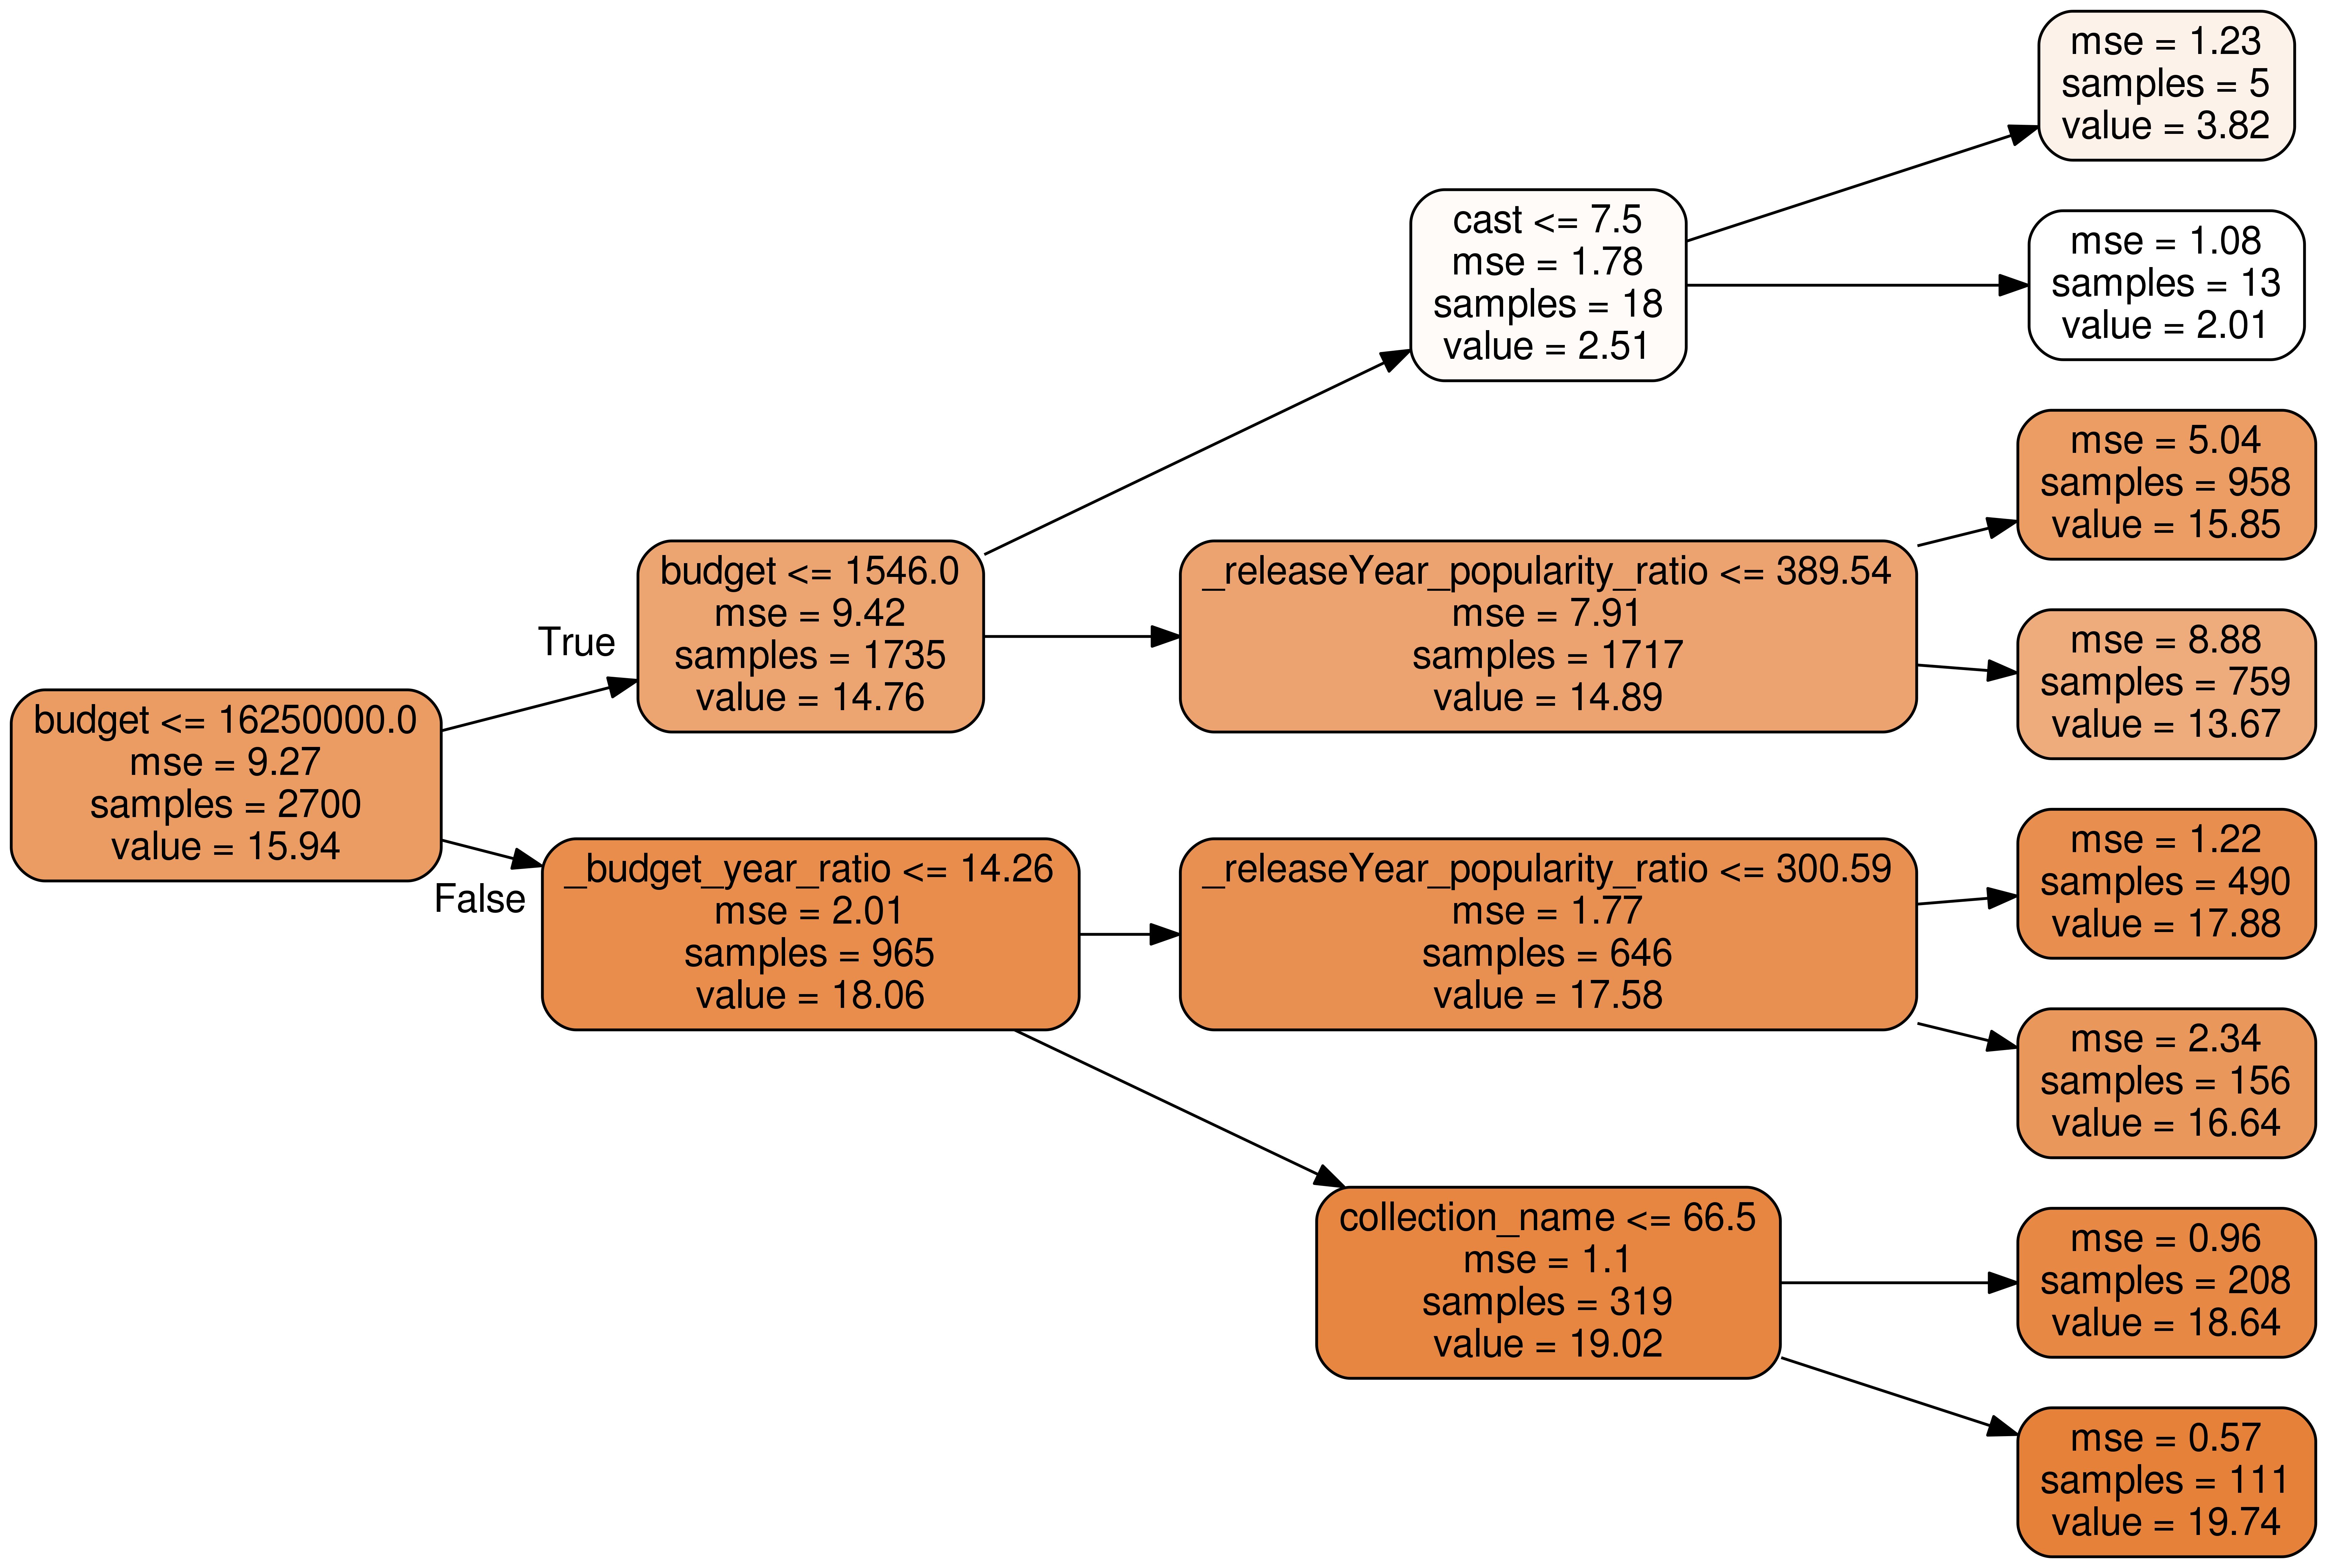

In [44]:
# Export as dot file
export_graphviz(
    rf.estimators_[0], 
    out_file='tree.dot', 
    feature_names = X_train.columns,
    rounded = True, 
    proportion = False, 
    precision = 2, 
    filled = True,
    rotate = True
)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png', height = 600, width = 800)

#### Creating a deeper Single Tree

Previously, we set our *max_depth* to 3 to make the tree easy to visualize. Now, let's remove this hyperparameter and observe the difference in evaluation.

In [45]:
## Random Forest Regressor without hyperparameters

rf = RandomForestRegressor(
    n_estimators = 1, 
    bootstrap = False, 
    n_jobs = -1, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)

Train R2:   0.9999999999841018
Valid R2:   0.16993412976148625
Train RMSE: 1.2140760502686808e-05
Valid RMSE: 2.6682494427077352
Train RMSLE: 6.691100972664938e-07
Valid RMSLE: 0.22258081195037618


As expected, we have a training R squared of 1. This is because each observation in the training data is a leaf node and can be accounted for easily. Our R squared and validation score on test data, however, has decreased tremendously.

#### Bagging Trees

As we saw, our deep single tree massively overfit. Bagging, an important concept in ensembling, suggests that if we create a large number of such trees built on random samples of data and average their errors, we will get a good model. To illustrate this process better, let's return to our default random forest with no hyperparameter tuning.

In [46]:
rf = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)
rf.fit(X_train, y_train)
print_rf_score(rf)

Train R2:   0.9210210821618376
Valid R2:   0.5441445681270172
Train RMSE: 0.8557132218037725
Valid RMSE: 1.9773507628070819
Train RMSLE: 0.08538072279322163
Valid RMSLE: 0.17475482405367157


The value of *n_estimators* is 10, which is the default. Let's grab predictions for each of these 10 trees and look at how they perform on the first validation sample.

In [47]:
tree_preds = np.stack([tree.predict(X_valid) for tree in rf.estimators_])
print(f' Individual Tree Predictions: {[np.around(tree_preds[:,0], 1)]}')
print(f' Mean of Tree Predictions:    {np.mean(tree_preds[:,0])}')
print(f' Ground truth for sample:     {y_valid[0]}')

 Individual Tree Predictions: [array([17.3, 13.1, 16.8,  7.2, 11.6, 14.9, 11.6, 15.7, 10.2,  7.2])]
 Mean of Tree Predictions:    12.571137942247876
 Ground truth for sample:     16.326300330915824


As is visible, the predictions for individual trees are all over the place but their average is fairly reasonable.

#### Visualizing the imapct of additional Trees

In [48]:
%%time
train_scores_r2 = []
valid_scores_r2 = []
train_scores_rmse = []
valid_scores_rmse = []
for trees in tqdm_notebook(range(1, 100)):
    rf = RandomForestRegressor(n_estimators = trees, n_jobs = -1, random_state = 42)
    rf.fit(X_train, y_train)
    train_scores_r2.append(rf.score(X_train, y_train))
    valid_scores_r2.append(rf.score(X_valid, y_valid))    
    train_scores_rmse.append(rmse(rf.predict(X_train), y_train))
    valid_scores_rmse.append(rmse(rf.predict(X_valid), y_valid))



CPU times: user 3min 49s, sys: 2.25 s, total: 3min 51s
Wall time: 1min 47s


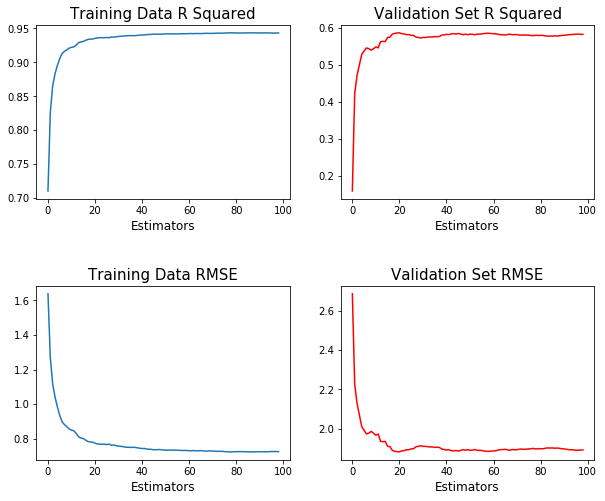

In [49]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.5)

# Plot 1: Train R2
plt.subplot2grid((2,2), (0,0))

plt.plot(train_scores_r2)
plt.title('Training Data R Squared', fontsize = 15)
plt.xlabel('Estimators', fontsize=12)

# Plot 2: Valid R2
plt.subplot2grid((2,2), (0,1))

plt.plot(valid_scores_r2, color='r')
plt.title('Validation Set R Squared', fontsize = 15)
plt.xlabel('Estimators', fontsize=12)

# Plot 1: Train RMSE
plt.subplot2grid((2,2), (1,0))

plt.plot(train_scores_rmse)
plt.title('Training Data RMSE', fontsize = 15)
plt.xlabel('Estimators', fontsize=12)

# Plot 2: Valid RMSE
plt.subplot2grid((2,2), (1,1))

plt.plot(valid_scores_rmse, color='r')
plt.title('Validation Set RMSE', fontsize = 15)
plt.xlabel('Estimators', fontsize=12)

plt.show()

#### Out of Bag Evaluation

To know if our validation score is worse because our model is overfitting or because the validation set is from a different distribution, or both, we can leverage a hyperparameter called *oob_score*, or Out of Bag score. The idea behind it is to calculate error on the training set while only including those trees in the calculation of a row's error where that row was not included in the training the tree. 

(how your model is working for new data, as in data that was not used to generate this tree)

If you have a lot of trees, all of the rows in the dataset should appear a few times in the out of bag samples. This approach is beneficial as we can see if our model generalizes, even if we have a small amount of data. We can avoid creating a separate validation set and lose valuable training data.

In [50]:
## Random Forest Regressor with changes # of estimators to 20, based on above graphs

rf = RandomForestRegressor(
    n_estimators = 20, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')

Train R2:   0.9344037448060729
Valid R2:   0.5863857119577194
Train RMSE: 0.779851975099894
Valid RMSE: 1.8835099339651589
Train RMSLE: 0.07954084118124734
Valid RMSLE: 0.1708298283970544
OOB Score:  0.5242965664679289


The Out of Bag R2 score is in the same range as the validation R2 score, which is good news.

(rules out potential problem of validation set is from a different distribution)

#### Min_Samples_Leaf

To prevent overfitting, we will tune min_samples_leaf. This will reduce the depth of our trees by a couple of levels

(being less picky)

In [51]:
rf = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')

Train R2:   0.8396014114731217
Valid R2:   0.6173340357508638
Train RMSE: 1.2194750638176621
Valid RMSE: 1.811674063120317
Train RMSLE: 0.12168986140679
Valid RMSLE: 0.16487311920498607
OOB Score:  0.5568598945847674


#### Max_Features

In [52]:
rf = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1, 
    oob_score = True, 
    random_state = 42
)
rf.fit(X_train, y_train)
print_rf_score(rf)
print(f'OOB Score:  {rf.oob_score_}')

Train R2:   0.814542678494252
Valid R2:   0.6243707681656878
Train RMSE: 1.3112776066074272
Valid RMSE: 1.7949396028453612
Train RMSLE: 0.13132111775872715
Valid RMSLE: 0.1642016983659632
OOB Score:  0.5665464314177606


#### Random Forest with Hyperparameter Tuning

In [53]:
## Final Random Forest Regressor with hyperparamter optimization

rf = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42,
)
rf.fit(X_train, y_train)
print_rf_score(rf)
## Out of Bag score
print(f'OOB Score:  {rf.oob_score_}')

Train R2:   0.814542678494252
Valid R2:   0.6243707681656878
Train RMSE: 1.3112776066074272
Valid RMSE: 1.794939602845361
Train RMSLE: 0.13132111775872715
Valid RMSLE: 0.1642016983659632
OOB Score:  0.5665464314177606


#### Predictions for Random Forest model

In [54]:
predictions = np.expm1(rf.predict(rf_test))
submission['revenue'] = np.round(predictions)
submission.to_csv('submission_simple_rf.csv', index = False)

## Ensembling

### XGBoost

In [55]:
def xgtrain(X_train, X_valid, y_train, y_valid):
    regressor = XGBRegressor(
        n_estimators = 50000, 
        learning_rate = 0.001,
        max_depth = 6, 
        subsample = 0.3, 
        colsample_bytree = 0.2
        )
    
    regressor_ = regressor.fit(
        X_train.values, y_train.values, 
        eval_metric = 'rmse', 
        eval_set = [
            (X_train.values, y_train.values), 
            (X_valid.values, y_valid.values)
        ],
        verbose = 1000,
        early_stopping_rounds = 500,
        )
    
    return regressor_

In [56]:
%%time
regressor_ = xgtrain(X_train, X_valid, y_train, y_valid)

[0]	validation_0-rmse:15.7199	validation_1-rmse:16.0406
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:6.17114	validation_1-rmse:6.3308
[2000]	validation_0-rmse:2.90661	validation_1-rmse:3.00041
[3000]	validation_0-rmse:1.96332	validation_1-rmse:2.07202
[4000]	validation_0-rmse:1.70641	validation_1-rmse:1.86794
[5000]	validation_0-rmse:1.60165	validation_1-rmse:1.82125
[6000]	validation_0-rmse:1.5316	validation_1-rmse:1.80291
[7000]	validation_0-rmse:1.47237	validation_1-rmse:1.79277
[8000]	validation_0-rmse:1.41972	validation_1-rmse:1.78862
[9000]	validation_0-rmse:1.37115	validation_1-rmse:1.78369
[10000]	validation_0-rmse:1.32408	validation_1-rmse:1.78103
[11000]	validation_0-rmse:1.2805	validation_1-rmse:1.77818
[12000]	validation_0-rmse:1.23916	validation_1-rmse:1.77619
Stopping. Best iteration:
[12082]	validation_0-rmse:1.23572	validation_1-rms

### Light GBM

In [57]:
def lgbtrain(X_train, y_train, X_valid, y_valid):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2_root'},
        'max_depth': 4,
        'learning_rate': 0.001,
        'feature_fraction': 0.3,
        'bagging_fraction': 1,
        'bagging_freq': 1,
    }
    
    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets = lgb_eval,
        num_boost_round=50000,
        early_stopping_rounds=500,
        verbose_eval = 1000
    )
    
    return gbm

In [58]:
%%time
gbm = lgbtrain(X_train, y_train, X_valid, y_valid)

Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's rmse: 2.21976
[2000]	valid_0's rmse: 1.9861
[3000]	valid_0's rmse: 1.90518
[4000]	valid_0's rmse: 1.86444
[5000]	valid_0's rmse: 1.84107
[6000]	valid_0's rmse: 1.83217
[7000]	valid_0's rmse: 1.82776
[8000]	valid_0's rmse: 1.82111
[9000]	valid_0's rmse: 1.81811
[10000]	valid_0's rmse: 1.81639
[11000]	valid_0's rmse: 1.81438
[12000]	valid_0's rmse: 1.81317
[13000]	valid_0's rmse: 1.81204
[14000]	valid_0's rmse: 1.81078
[15000]	valid_0's rmse: 1.80983
Early stopping, best iteration is:
[15431]	valid_0's rmse: 1.80952
CPU times: user 9.58 s, sys: 914 ms, total: 10.5 s
Wall time: 10.5 s


## Feature Importances

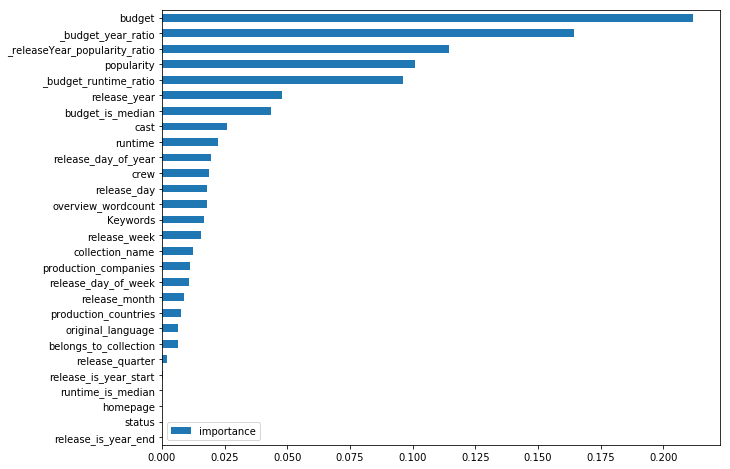

In [59]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=True)
feature_importances.plot(kind = 'barh', figsize = (10,8))
plt.show()

### Preparing Submission

In [60]:
## Averaging 3 predictions

predictions = np.expm1(rf.predict(rf_test)) + np.expm1(regressor_.predict(rf_test.values)) + np.expm1(gbm.predict(rf_test.values))
predictions /= 3

In [61]:
submission['revenue'] = np.round(predictions)

In [62]:
submission.head()

,id,revenue
0,3001,1134829.0
1,3002,2490936.0
2,3003,5454834.0
3,3004,3993857.0
4,3005,695587.0


In [63]:
#submission.to_csv('submission_ensemble.csv', index = False)

Get Output files without committing

In [64]:
from IPython.display import FileLinks
FileLinks('.')

./
  submission_simple_rf.csv
  submission_budget_linreg.csv
  __notebook__.ipynb
  train.csv
  tree.dot
  tree.png